# Creating the AI Agent with some custom tools

In [15]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain.tools import Tool
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
import os, requests
from langchain_ollama import ChatOllama

In [17]:
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
langsmith_api_key = os.getenv("LANGSMITH_API_KEY")

os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph_Agent"

In [18]:
llm = ChatOllama(model="qwen3:8b")

## custom tools

In [19]:
def hello_tool_func(input: str) -> str:
    print(f"Received input inside tool: {input}")
    greeting_prompt = (
        f"Generate a friendly greeting for {input}. Keep it short and cheerful."
    )
    greeting_response = llm.invoke(greeting_prompt).content
    return greeting_response


hello_tool = Tool(
    name="hello_tool",
    func=hello_tool_func,
    description="A tool that greets the user with a hello message.",
)

In [20]:
def find_user_details(input: str) -> str:
    users = requests.get("https://jsonplaceholder.typicode.com/users").json()
    for user in users:
        if user["name"].lower() in input.lower():
            user_describe_prompt = f"Describe the user with details {user['name']}, Email: {user['email']}, Lives in {user['address']['city']} at {user['address']['suite']}. He works in {user['company']['name']}. Tell as if you are giving a brief introduction about the user. For example say the user name is ABC with email XYZ, lives in the city EFG and works in the company HIJ. Keep it short and concise."
            return llm.invoke(user_describe_prompt).content

    return "No user found with that name."


find_user_tool = Tool(
    name="find_user_tool",
    func=find_user_details,
    description="A tool that finds user details by name.",
)

In [21]:
tools = [hello_tool, find_user_tool]
llm = llm.bind_tools(tools=tools)

In [22]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [23]:
def chatbot(state: State) -> dict:
    return {"messages": [llm.invoke(state["messages"])]}

In [24]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

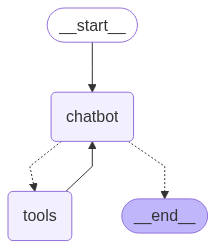

In [25]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [26]:
user_inputs = [
    "Hello, my name is Alice.",
    "Can you find a user with name Clementine Bauch?",
    "Can you find a user with name Patricia Lebsack?",
]

In [27]:
for user_input in user_inputs:
    events = graph.stream({"messages": [("user", user_input)]}, stream_mode="values")

    for event in events:
        print(event["messages"][-1].content)

Hello, my name is Alice.
<think>
Okay, the user introduced themselves as Alice. Let me check the available tools. There's hello_tool and find_user_tool. The hello_tool is for greeting, and find_user_tool is for finding user details by name. Since the user provided their name, maybe I should use find_user_tool to get more info. But the user hasn't asked for anything specific yet. Wait, the hello_tool is meant for a greeting. The user already said hello, so perhaps the appropriate response is to greet them back and offer help. Maybe I don't need to call any tool here. Let me see the functions again. The hello_tool's description says it greets the user with a hello message. The parameters require __arg1, which is a string. Since the user mentioned their name, maybe I should use the hello_tool with their name as the argument. Alternatively, maybe the find_user_tool is to retrieve details, but the user hasn't asked for that. The best approach is to respond politely, using the hello_tool to 